<a href="https://colab.research.google.com/github/shreejitp/AnomalyDetection/blob/main/Multivariate_Gaussian_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multivariate Guassian Distribution for Anomaly Detection** 

Towards DS article- https://towardsdatascience.com/wondering-how-to-build-an-anomaly-detection-model-87d28e50309

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

This example is just using a toy dataset

- Link to datasets:
https://github.com/abhishek-Kumar009/Machine-Learning/tree/master/AnomalyDetectionScratch

Also uploaded the datasets to Gdrive- 
https://drive.google.com/drive/folders/1VJM7pMHdV-pB5FHXxr0FiZ3MAySfTBt5



In [4]:
dataset = sio.loadmat('/content/drive/MyDrive/Data_Science/Datasets/anomalyData.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

X contains the training dataset
Xval contains cross validation set 
‘yval’ the corresponding output for the ‘Xval

In [10]:
# The loaded data here is of the dict type 
type(dataset)

dict

In [15]:
print(X[0])  # There is no target in train??
print(Xval[0])
print(yval[0]) # Target for Validation

[13.04681517 14.74115241]
[15.79025979 14.9210243 ]
[0]


In [16]:
X.shape

(307, 2)

As you can see there are 307 training examples and each having 2 features. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset {x(1), . . . , x(m)}.


You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset


Text(0, 0.5, 'Throughput(mb/s)')

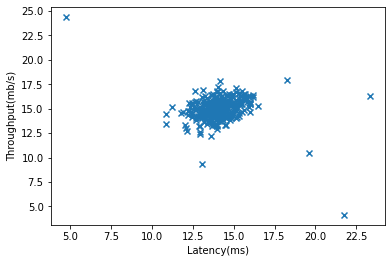

In [18]:
# Plotting the training set using matplotlib
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')

Writing a function to calculate the Mean and the Variance for a feature

In [19]:
def estimateGaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2

mu, sigma2 = estimateGaussian(X)

In [21]:
# Calling the function above to calculate the Mean and the Variance for the 2 features in X -- >>
mu, sigma2 = estimateGaussian(X)  # You end with an array for mu and an array for Sigma2 
print('mean: ',mu,' variance: ',sigma2)   

mean:  [[14.11222578 14.99771051]]  variance:  [[1.83263141 1.70974533]]


Now that we have the mean and variance we need to calculate the probability of the training examples in order to decide which examples are anomalous. We can do it by using the Multivariate Gaussian model

The multivariate Gaussian is used to find the probability of each example and based on some threshold value we decide whether to flag an anomaly or not

In [22]:
def multivariateGaussian(X, mu, sigma2):
     n = np.size(sigma2, 1)
     m = np.size(sigma2, 0)
     #print(m,n)
     
     if n == 1 or m == 1:
        # print('Yes!')
         sigma2 = np.diag(sigma2[0, :])
     #print(sigma2)
     X = X - mu
     pi = math.pi
     det = np.linalg.det(sigma2)
     inv = np.linalg.inv(sigma2)
     val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
     #print(val.shape)
     p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
     
     return p  # IF this p value < THRESHOLD; (FLAG AS ANOMALY)

In [23]:
p = multivariateGaussian(X, mu, sigma2)
print(p.shape)

(307, 1)


Thus, you’ve successfully calculated the probabilities. Next, you’ve to calculate to the threshold value using some labelled data. Let’s see how to do this

In [25]:
pval = multivariateGaussian(Xval, mu, sigma2)

In [26]:
#### Function for Selecting the best Threshold ### 
### You are passing the labels of the validation set and the pvalues of the validation set 
def selectThreshHold(yval, pval):
    
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    stepsize = (np.max(pval) - np.min(pval))/1000
        
    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)
    
    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0
        
        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            print('Warning dividing by zero!!')          
       
    return bestF1, bestEpsilon

First, we find the stepsize to have a wide range of threshold values to decide the best one. We use the F1 score method to determine the best parameters i.e bestepsilon and bestF1. Predict anomaly if pval<epsilon that gives a vector of binary values in the variable predict. F1 score takes into consideration precision and recall

In [27]:
F1, epsilon = selectThreshHold(yval, pval)
print('Epsilon and F1 are:',epsilon, F1)

Warning dividing by zero!!
Epsilon and F1 are: 8.990852779269493e-05 0.8750000000000001


Now, we have the best epsilon value and we are now in a position to calculate the anomalies on the training data’s probability. We also call the anomalies as outliers

In [28]:
outl = (p < epsilon)

In [32]:
outl[0:10]

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

We need to return the indices of the outliers to identify the faulty servers. This gives us a vector with binary entries where 1 means anomaly and 0 means normal

In [34]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [36]:
listOfOutliers=findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers:', count_outliers)
print('\n',listOfOutliers)



Number of outliers: 6

 [300, 301, 303, 304, 305, 306]


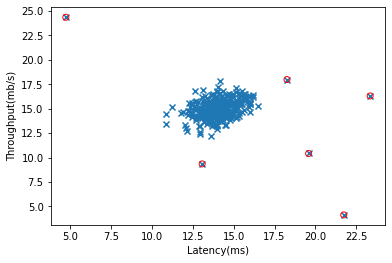

In [37]:
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(X[listOfOutliers,0], X[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r') # Marking the outliers here
plt.show()

Applying the same on a test Dataset

In [41]:
newDataset = sio.loadmat('/content/drive/MyDrive/Data_Science/Datasets/anomalyDataTest.mat')

Xtest = newDataset['X']
Xvaltest = newDataset['Xval']
yvaltest = newDataset['yval']

In [42]:
# Completely new sets of values are calculated- 
# It is not like a supervised Algorith --- Anomalies are outliers (they can't be trained)
## 

mutest, sigma2test = estimateGaussian(Xtest)
ptest = multivariateGaussian(Xtest, mutest, sigma2test)
pvaltest = multivariateGaussian(Xvaltest, mutest, sigma2test)

F1test, epsilontest = selectThreshHold(yvaltest, pvaltest)
print('\nBest epsilon and F1 are\n',epsilontest, F1test)

Warning dividing by zero!!

Best epsilon and F1 are
 1.3772288907613575e-18 0.6153846153846154


In [43]:
outliersTest = ptest < epsilontest
listOfOl = findIndices(outliersTest)

print('\n\n Outliers are:\n',listOfOl)
print('\n\nNumber of outliers are: ',len(listOfOl))



 Outliers are:
 [9, 20, 21, 30, 39, 56, 62, 63, 69, 70, 77, 79, 86, 103, 130, 147, 154, 166, 175, 176, 198, 209, 212, 218, 222, 227, 229, 233, 244, 262, 266, 271, 276, 284, 285, 288, 289, 290, 297, 303, 307, 308, 320, 324, 338, 341, 342, 344, 350, 351, 353, 365, 369, 371, 378, 398, 407, 420, 421, 424, 429, 438, 452, 455, 456, 462, 478, 497, 518, 527, 530, 539, 541, 551, 574, 583, 587, 602, 613, 614, 628, 648, 674, 678, 682, 685, 700, 702, 705, 713, 721, 741, 750, 757, 758, 787, 831, 834, 836, 839, 846, 870, 885, 887, 890, 901, 911, 930, 939, 940, 943, 951, 952, 970, 975, 992, 996]


Number of outliers are:  117


Great! This brings us to the end of the exercise 

Questions: 
1. Here we applied Multivariate Guassian Distribution thinking that the distribution of all features is Normal (True?)

2. What happens the distribution is not really normal (Can we so some transformations)

3. What other distributions can be considered for Outlier Detection?


